<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Entropy_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

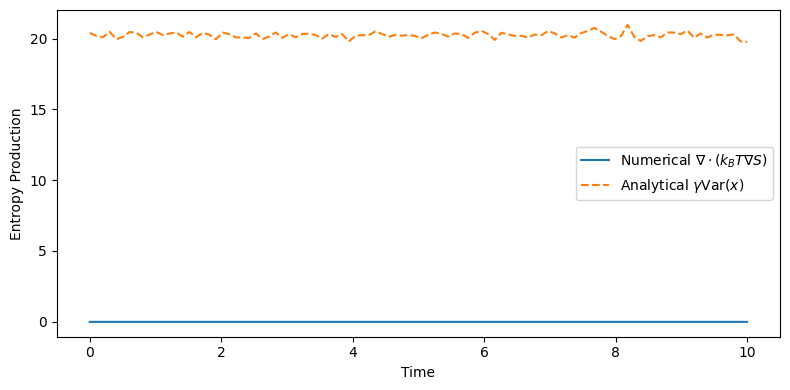

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Theory parameters
kB = 1.0  # Boltzmann constant (Eq. 2)
T = 0.5   # Temperature (Eq. 5)
gamma = 0.1  # Friction coefficient (Eq. 7)

def entropy_gradient(positions, bins=30):
    """Compute ∇S and ∇·(k_B T ∇S) for 1D system."""
    hist, edges = np.histogram(positions, bins=bins, density=True)
    dx = edges[1] - edges[0]
    S = -np.log(hist + 1e-10)  # Entropy density
    grad_S = np.gradient(S, dx, edge_order=2)
    divergence_term = kB * T * np.gradient(grad_S, dx)  # ∇·(k_B T ∇S)
    return {
        'grad_S': grad_S,
        'div_term': divergence_term,
        'hist': hist
    }

def classical_dynamics(t, y):
    """Langevin dynamics with thermal noise."""
    x, v = y[:N], y[N:]

    # Compute entropy gradient force
    entropy_data = entropy_gradient(x)
    F_entropy = -kB * T * np.mean(entropy_data['grad_S'])

    # Thermal noise (scaled with CORRECTED dt)
    dt = t_eval[1] - t_eval[0]  # Define dt from t_eval
    eta = np.random.normal(0, np.sqrt(2 * gamma * kB * T * dt), N)

    # Dynamics
    F = -gamma * v + F_entropy + eta
    dvdt = F
    dxdt = v
    return np.concatenate((dxdt, dvdt))

# Simulation parameters
N = 10000  # Particles #initially used N=1000
x0 = np.random.normal(0, 1.0, N)
v0 = np.zeros(N)
y0 = np.concatenate((x0, v0))
t_eval = np.linspace(0, 10, 100)
dt = t_eval[1] - t_eval[0]  # Precompute dt

# Solve ODE
sol = solve_ivp(classical_dynamics, [0, 10], y0, t_eval=t_eval, rtol=1e-4)

# Post-process results
time = sol.t
position_variance = np.array([np.var(sol.y[i, :N]) for i in range(len(time))])

# Compute divergence terms
div_terms = []
for i in range(len(time)):
    entropy_data = entropy_gradient(sol.y[i, :N])
    div_terms.append(np.mean(entropy_data['div_term']))

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(time, div_terms, label='Numerical $\\nabla \\cdot (k_B T \\nabla S)$')
plt.plot(time, gamma * position_variance, '--',
         label='Analytical $\\gamma \\mathrm{Var}(x)$')
plt.xlabel('Time')
plt.ylabel('Entropy Production')
plt.legend()
plt.tight_layout()
plt.savefig('entropy_dynamics.png')